In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

import numpy as np
import pandas as pd
import json
import scienceplots
import wandb
import pickle
from matplotlib.colors import to_rgba

from copy import deepcopy

from src.problem import Instance
from src.utils import load_all_results

import os 
os.environ["PATH"] += os.pathsep + '/home/bruno/texlive/2023/bin/x86_64-linux/'

plt.style.use(['science','vibrant'])
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

instances_dir = Path('../data/raw/')
results_dir = Path('../data/results/')
opts_dir = Path('../data/interim')

/home/bruno/miniconda3/envs/satgnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# scheduling example

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-10


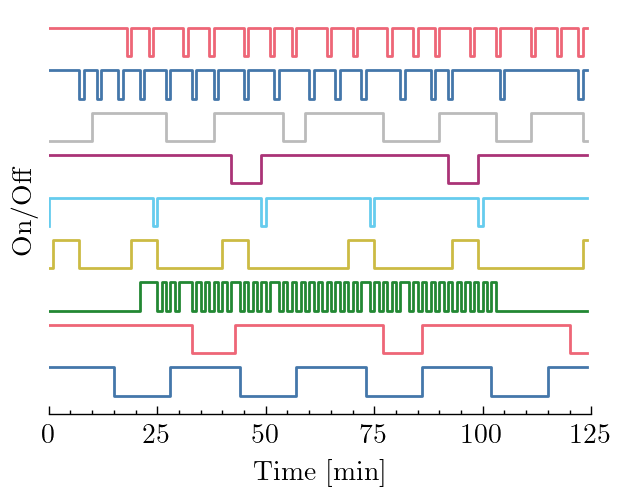

In [3]:
instance_fpath = next(instances_dir.glob('125_9_*.json'))
instance = Instance.from_file(instance_fpath)

opt_fp = opts_dir/(instance_fpath.name.replace('.json', '_opt.npz'))
obj, gap, runtime, X = np.load(opt_fp).values()

x = X[instance.vars_names.find('x(') >= 0]
x = x.reshape((instance.jobs, instance.T))

for i, j in enumerate(x):
    plt.step(np.arange(instance.T), j + i*1.5, label=i)

plt.xlim(0,instance.T)
plt.ylabel('On/Off')
plt.xlabel('Time [min]')

ax = plt.gca()
ax.set_yticks([])
ax.set_xticks(np.linspace(0,125,6), )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.gcf().set_size_inches((6,6))

plt.tick_params(top=False, which='both')
plt.savefig('../schedule_example.pdf')
plt.show()

# dataset

In [10]:
df = load_all_results(f"baseline_bs_0", results_dir, opts_dir)
df['rel_obj'] = df['objective'] / df['opt_obj']
df['solved'] = np.abs(df['gap']) == 0.0
df.head()

/home/bruno/sat-gnn/notebooks/../src/utils.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_to_feasible'].fillna(TIME_BUDGET, inplace=True)


,size,size_id,opt_obj,infeasible,runtime,objective,gap,primal_curve,time_to_feasible,rel_obj,solved
0,18,131,12397,False,120.003327,12398.0,0.005585,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",36.753,1.000081,False
1,9,187,3008,False,120.000222,3008.0,0.006766,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",28.794,1.0,False
2,18,76,10891,False,120.002757,10887.0,0.067752,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",19.165,0.999633,False
3,9,112,3994,False,120.000197,3994.0,0.000513,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.932,1.0,False
4,13,68,6452,False,120.000682,6419.0,0.020831,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",36.517,0.994885,False


In [11]:
df['size'].value_counts()

size
9     206
13    205
18    201
20     40
22     40
24     40
26     20
Name: count, dtype: int64

In [12]:
1 - df.groupby('size')['infeasible'].mean()

size
9     0.980583
13    0.960976
18    0.845771
20    0.775000
22    0.600000
24    0.475000
26    0.450000
Name: infeasible, dtype: float64

In [13]:
df.groupby('size')['solved'].mean()

size
9     0.203883
13    0.034146
18    0.000000
20    0.000000
22    0.000000
24    0.000000
26    0.000000
Name: solved, dtype: float64

In [14]:
df[~df['infeasible']].groupby('size')['gap'].mean()

size
9     0.033774
13    0.050787
18    0.092675
20    0.125126
22    0.167758
24    0.313383
26    0.217188
Name: gap, dtype: float64

In [15]:
df.groupby('size')['rel_obj'].mean()

size
9     0.978602
13    0.953452
18    0.826477
20    0.749931
22    0.563577
24    0.423606
26    0.409473
Name: rel_obj, dtype: object

In [16]:
for s in [9,13,18,20,22,24]:
    model = Instance.from_file(f'../data/raw/125_{s}_0.json').to_scip(enable_primal_dual_integral=False)
    m = len(model.getConss())
    n = np.load(f"../data/interim/125_{s}_0_opt.npz")['arr_3'].size
    print(f"{s}: {m} x {n}")
    # fs = Path('../data/interim/').glob(f"125_{s}_*_opt.npz")
    # ns = list()
    # for f in fs:
    #     n = np.load(f)['arr_3'].size
    #     ns.append(n)
    # assert min(ns) == max(ns)

9: 7518 x 2250
13: 10618 x 3250
18: 13434 x 4500
20: 14633 x 5000
22: 16430 x 5500
24: 18664 x 6000


# feasibility classification

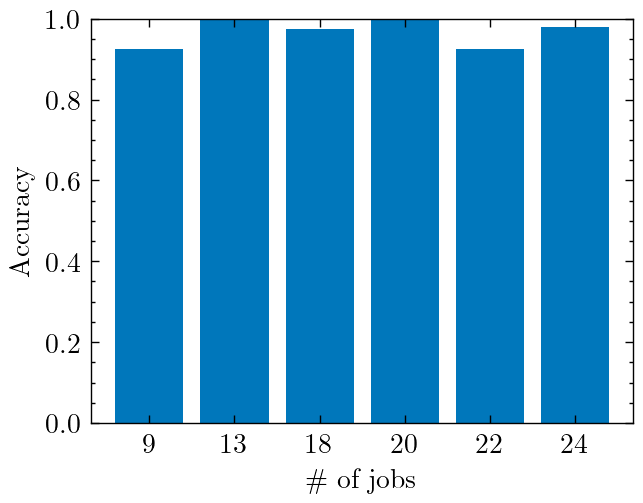

In [18]:
from collections import OrderedDict

accuracies = OrderedDict()
for size in [9,13,18,20,22,24]:
    runs = wandb.Api().runs(path='brunompac/sat-gnn', filters={'group': f'FeasClass-AcrossInstances-{size}'}, order='-created_at')
    run = runs[0]

    accuracies[size] = run.summary['val_loss_accuracy']

plt.bar(np.arange(len(accuracies.values())), accuracies.values(), tick_label=list(accuracies.keys()), color=colors[1])

plt.xlabel('\# of jobs')
plt.ylabel('Accuracy')

plt.ylim(0,1)
# plt.minorticks_off()
plt.gcf().gca().set_xticks(list(), minor=True)
# plt.savefig('../accuracy_classification_across_instances.pdf')
plt.show()

(array([[   nan, 0.4375, 0.3125, 0.3125],
        [0.4375,    nan, 0.8125, 1.    ],
        [0.3125, 0.8125,    nan, 1.    ],
        [0.3125, 1.    , 1.    ,    nan]]),
 array([[nan,  4.,  3.,  3.],
        [ 4., nan,  6.,  7.],
        [ 3.,  6., nan,  7.],
        [ 3.,  7.,  7., nan]]))

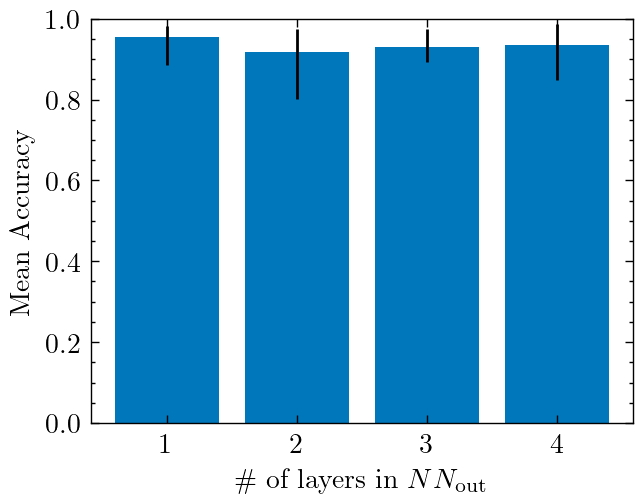

In [41]:
from scipy.stats import wilcoxon, ks_1samp

runs = wandb.Api().runs(path='brunompac/sat-gnn', filters={'group': f'FeasClass-Ablation'}, order='-created_at')

n_output_layerss = [1,2,3,4]
accs = {n: list() for n in n_output_layerss }

fig, ax = plt.subplots()

for run in runs:
    n_output_layers = run.config['n_output_layers']
    if len(accs[n_output_layers]) < 5:
        accs[n_output_layers].append(run.summary['val_loss_accuracy'])

# for n_output_layers, accs_n in accs.items():
#     print(n_output_layers, accs_n)
#     ax.scatter([n_output_layers,] * len(accs_n), accs_n, marker='_', label=n_output_layers)
mean_accs = np.mean(list(accs.values()), axis=1)
min_accs = np.min(list(accs.values()), axis=1)
max_accs = np.max(list(accs.values()), axis=1)
ax.bar(n_output_layerss, mean_accs, yerr=np.vstack([mean_accs - min_accs, max_accs - mean_accs]), color=colors[1])

ax.set_ylabel('Mean Accuracy')
ax.set_xlabel('\# of layers in $NN_{\\text{out}}$')

ax.set_ylim(0.,1.0)
ax.set_xticks([], minor=True)
fig.savefig('../feasibility_classification_ablation_accuracy.pdf')
fig.show()

X, Y = np.meshgrid(n_output_layerss, n_output_layerss)

ps = np.zeros_like(X, dtype=float)
kss = np.zeros_like(X, dtype=float)

for i in range(len(n_output_layerss)):
    for j in range(len(n_output_layerss)):
        if i == j:
            ps[i, j] = np.nan
            kss[i, j] = np.nan
        else:
            ks_stat, p_value = wilcoxon(accs[n_output_layerss[i]], accs[n_output_layerss[j]])
            kss[i, j] = ks_stat
            ps[i, j] = p_value

ps, kss

# optimality prediction

Optimals
0.28874673982384386


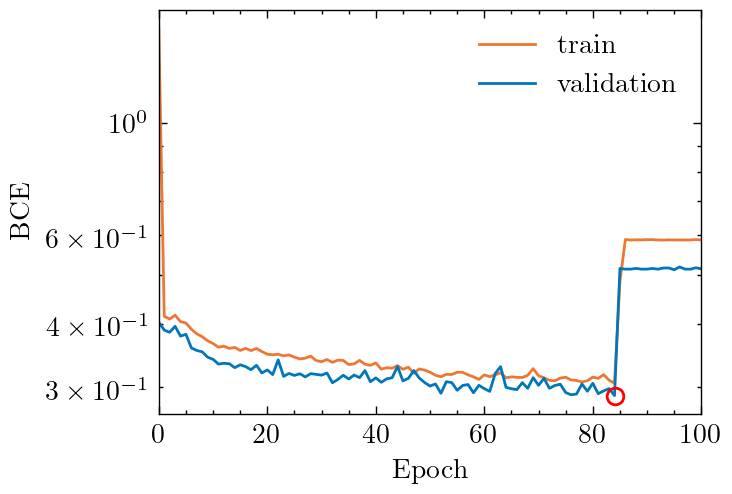

In [3]:
net_id = 'gbmooeqh'

api = wandb.Api()
run = api.run('brunompac/sat-gnn/'+net_id)
training_type = run.group[len('Best-'):]

df = run.history()
train_loss = df.train_loss.values
val_loss = df.val_loss.values

best_val_loss = run.summary['best_val']

fig, ax = plt.subplots()

ax.plot(train_loss, label='train')
ax.plot(val_loss, label='validation')
ax.plot(np.where(val_loss == best_val_loss)[0], [best_val_loss], 'o', color='r', fillstyle='none')

print(training_type)
print(best_val_loss)

# plt.title('Best Solution')
plt.ylabel('BCE')
plt.xlabel('Epoch')
plt.legend()
plt.yscale('log')
plt.xlim(0,100)
# plt.savefig('../training_curve_optimal.pdf')
plt.show()

MultiTarget
0.2451411026189783


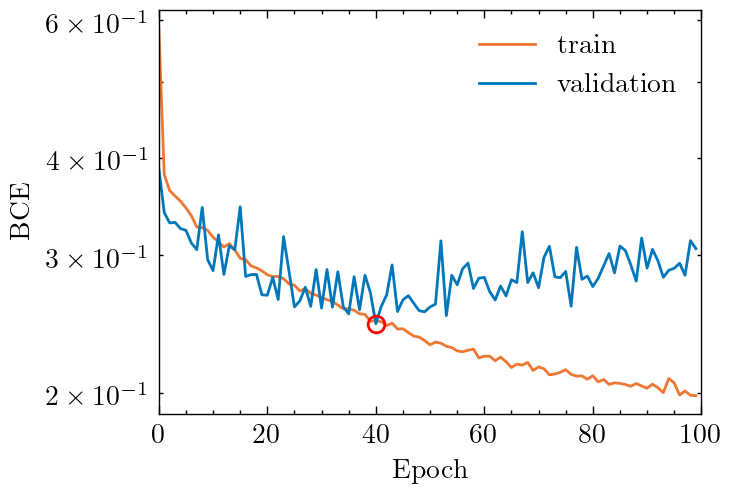

In [5]:
net_id = 'xae9giql'

api = wandb.Api()
run = api.run('brunompac/sat-gnn/'+net_id)
training_type = run.group[len('Best-'):]

df = run.history()
train_loss = df.train_loss.values
val_loss = df.val_loss.values

best_val_loss = run.summary['best_val']

fig, ax = plt.subplots()

ax.plot(train_loss * 500, label='train')
ax.plot(val_loss * 500, label='validation')
ax.plot(np.where(val_loss == best_val_loss)[0], [best_val_loss*500], 'o', color='r', fillstyle='none')

print(training_type)
print(best_val_loss * 500)

# plt.title('Multiple Solutions')
plt.ylabel('BCE')
plt.xlabel('Epoch')
plt.legend()
plt.yscale('log')
plt.xlim(0,100)
# plt.savefig('../training_curve_multi.pdf')
plt.show()

0.72445117335352
0.681499498045233


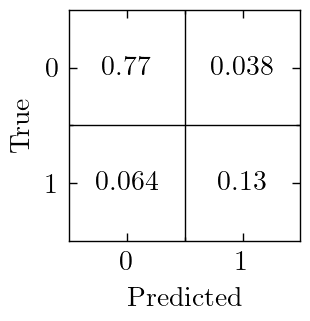

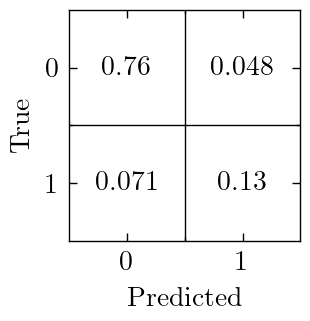

In [3]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib as mpl
transp_cmap = mpl.colors.ListedColormap([(1.,1.,1.,0.), (1.,1.,1.,0.)])

def get_all_preds_targets(net_id):
    with open(f'../{net_id}_preds_test.pkl', 'rb') as f:
        preds = pickle.load(f)

    df = pd.DataFrame(preds)

    def get_sol_from_json(fp):
        sol_npz = np.load('../data/interim/'+fp.name.replace('.json', '_opt.npz'))
        return sol_npz['arr_3']

    df['x_true'] = df['fp'].map(get_sol_from_json)

    return df

def plot_confusion_matrix(net_id, ax):
    df = get_all_preds_targets(net_id)

    X_hat = np.hstack(df['x_hat'].values)
    X_true = np.hstack(df['x_true'].values)

    cm = confusion_matrix(X_true >= 0.5, X_hat >= 0.5, normalize='all')

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # disp.plot(cmap='magma', ax=ax)

    # transparent cmap to avoid weird pdf saving without background problem
    disp.plot(cmap=transp_cmap, text_kw={'c': 'black'}, colorbar=False, ax=ax)

    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')

    ax.set_xticks([0.5], minor=True)
    ax.set_yticks([0.5], minor=True)
    ax.grid(True, which='minor', c='black')
 
    print(f1_score(X_true >= 0.5, X_hat >= 0.5))

    return ax

fig, ax = plt.subplots()
fig.set_size_inches(1.5,1.5)

ax = plot_confusion_matrix('xae9giql', ax)

fig.savefig('../confusion_matrix_ms.pdf')
fig.show()

fig, ax = plt.subplots()
fig.set_size_inches(1.5,1.5)

ax = plot_confusion_matrix('gbmooeqh', ax)

fig.show()
fig.savefig('../confusion_matrix_os.pdf')

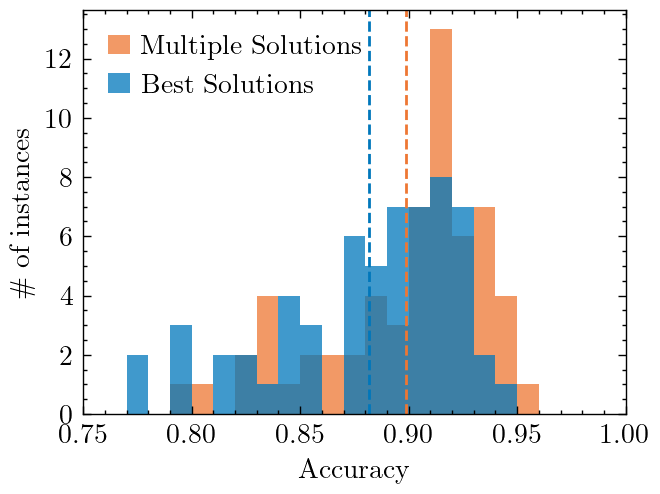

In [11]:
fig, ax = plt.subplots()

df = get_all_preds_targets('xae9giql')
accs_ms = [np.mean((x_hat >= 0.5) == (x_true >= 0.5)) for x_hat, x_true in zip(df['x_hat'].values, df['x_true'].values)]

df = get_all_preds_targets('gbmooeqh')
accs_os = [np.mean((x_hat >= 0.5) == (x_true >= 0.5)) for x_hat, x_true in zip(df['x_hat'].values, df['x_true'].values)]

_,_,patches_ms = plt.hist(accs_ms, bins=np.linspace(0.75,1,26), label='Multiple Solutions', alpha=.75)
_,_,patches_os = plt.hist(accs_os, bins=np.linspace(0.75,1,26), label='Best Solutions', alpha=.75)

ax.axvline(np.mean(accs_ms), linestyle='--', color=patches_ms.patches[0].get_facecolor()[0:3])
ax.axvline(np.mean(accs_os), linestyle='--', color=patches_os.patches[0].get_facecolor()[0:3])

ax.legend(handlelength=0.8, handletextpad=0.4)

ax.set_xlim(0.75,1.0)

ax.set_ylabel('\# of instances')
ax.set_xlabel('Accuracy')

fig.savefig('../histogram_accuracy.pdf')
fig.show()

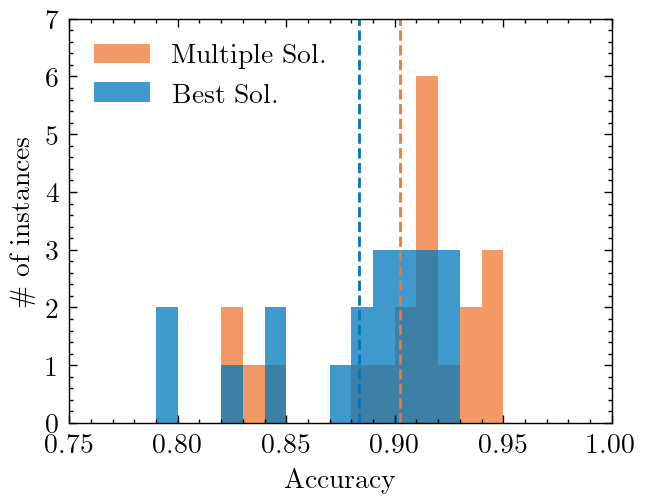

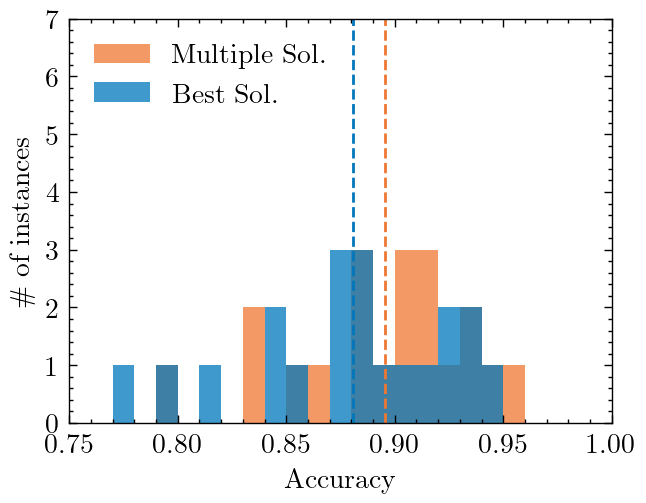

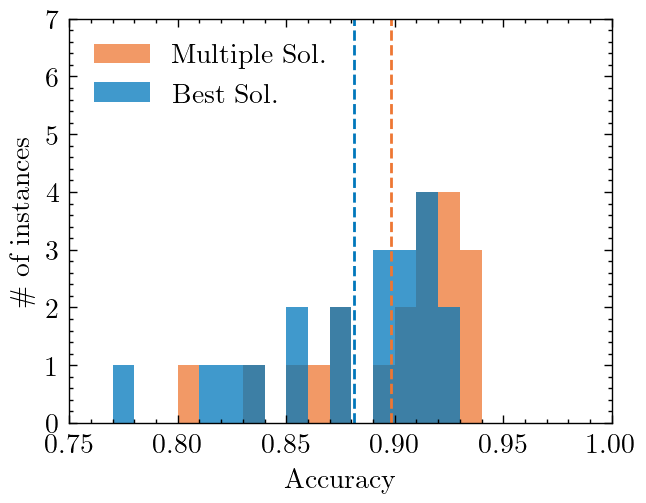

In [42]:
accss_ms = dict()
accss_os = dict()
for s in [20, 22, 24]:
    fig, ax = plt.subplots()

    df = get_all_preds_targets('xae9giql')
    df = df[df['size'] == s]
    accs_ms = [np.mean((x_hat >= 0.5) == (x_true >= 0.5)) for x_hat, x_true in zip(df['x_hat'].values, df['x_true'].values)]
    accss_ms[s] = accs_ms

    df = get_all_preds_targets('gbmooeqh')
    df = df[df['size'] == s]
    accs_os = [np.mean((x_hat >= 0.5) == (x_true >= 0.5)) for x_hat, x_true in zip(df['x_hat'].values, df['x_true'].values)]
    accss_os[s] = accs_ms

    _,_,patches_ms = plt.hist(accs_ms, bins=np.linspace(0.75,1,26), label='Multiple Sol.', alpha=.75)
    _,_,patches_os = plt.hist(accs_os, bins=np.linspace(0.75,1,26), label='Best Sol.', alpha=.75)

    ax.axvline(np.mean(accs_ms), linestyle='--', color=patches_ms.patches[0].get_facecolor()[0:3])
    ax.axvline(np.mean(accs_os), linestyle='--', color=patches_os.patches[0].get_facecolor()[0:3])

    ax.legend()

    ax.set_xlim(0.75,1.0)
    ax.set_ylim(0, 7)

    ax.set_ylabel('\# of instances')
    ax.set_xlabel('Accuracy')

    # fig.savefig(f'../histogram_accuracy_{s}.pdf')
    fig.show()

In [45]:
from scipy.stats import wilcoxon

wilcoxon(accss_ms[20], accss_ms[22]), wilcoxon(accss_ms[20], accss_ms[24]), wilcoxon(accss_ms[22], accss_ms[24])

(WilcoxonResult(statistic=92.0, pvalue=0.6476554870605469),
 WilcoxonResult(statistic=95.0, pvalue=0.7285060882568359),
 WilcoxonResult(statistic=89.0, pvalue=0.5705966949462891))

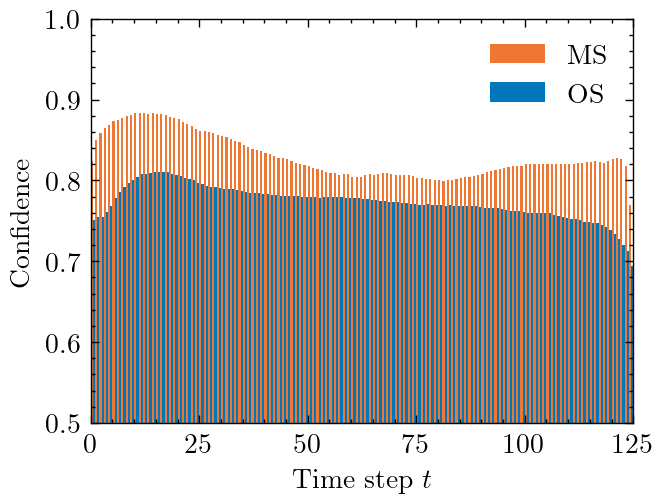

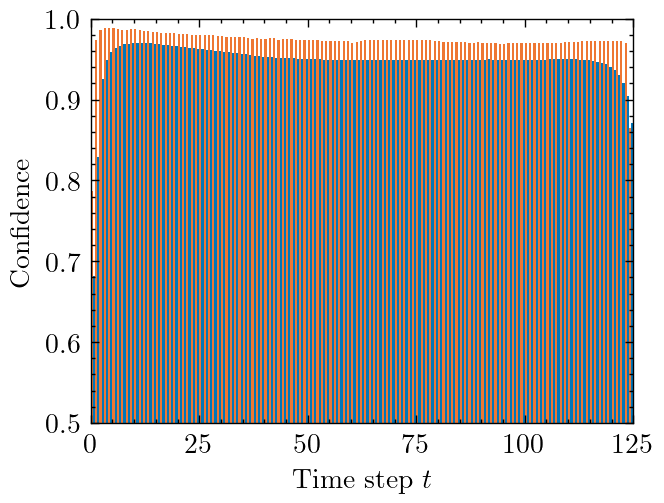

In [6]:
def get_confs(net_id):
    with open(f'../{net_id}_preds_test.pkl', 'rb') as f:
        preds = pickle.load(f)

    df = pd.DataFrame(preds)
    # df['x_hat'] = df['x_hat'].map(lambda t: t.numpy())
    df['conf'] = df['x_hat'].map(lambda x: np.where(x > 1-x, x, 1-x))

    X_confs = list()
    Phi_confs = list()
    for conf in df['conf'].values:
        X_confs.append(conf.reshape(-1, 125)[::2])
        Phi_confs.append(conf.reshape(-1, 125)[1::2])

    X_conf = np.vstack(X_confs)
    Phi_conf = np.vstack(Phi_confs)

    return X_conf, Phi_conf

def plot_confs(conf_ms, conf_bs, ax, legend=False):
    ax.bar(np.arange(125), conf_ms.mean(0), align='edge', width=.5, label='MS')
    ax.bar(np.arange(125) + 0.5, conf_bs.mean(0), align='edge', width=.5, label='OS')
    # ax.plot(np.arange(125), conf_ms.mean(0), label='MS')
    # ax.plot(np.arange(125) + 0.5, conf_bs.mean(0), label='OS')

    ax.set_xlim(0,125)
    ax.set_ylim(0.5,1)
    ax.set_xlabel('Time step $t$')
    ax.set_ylabel('Confidence')
    
    if legend:
        ax.legend()

    return ax

fig, ax = plt.subplots()

X_conf_ms, Phi_conf_ms = get_confs('xae9giql')
X_conf_bs, Phi_conf_bs = get_confs('gbmooeqh')

plot_confs(X_conf_ms, X_conf_bs, ax, legend=True)

fig.savefig('../X_confidences.pdf', dpi=500)
fig.show()

fig, ax = plt.subplots()

plot_confs(Phi_conf_ms, Phi_conf_bs, ax, legend=False)

# fig.savefig('../Phi_confidences.pdf', dpi=500)
fig.show()

# heuristics results

In [3]:
T = 125
TIME_BUDGET = 120

net_ids = {
    'Baseline': 'baseline',
    'Optimals': 'gbmooeqh',
    # 'Optimals-3Layers': 'hyhpo2jp',
    # 'Optimals-2Layers': 'psd9hfw1',
    # 'Optimals-1Layers': '8882wwy1',
    'MultiTarget': 'xae9giql',
    # 'MultiTarget-3Layers': 'txl6btoh',
    # 'MultiTarget-2Layers': '9m36bxug',
    # 'MultiTarget-1Layers': 'n9rhh317',
}

hps = {
    'Baseline':{
        'obj': {
            'bs': 'bs_0',
        },
        'feas': {
            'bs': 'bs_0',
        }
    },
    'Optimals':{
        'obj': {
            'ws': 'ws_750',
            'ef': 'ef_500',
            'tr': 'tr_1000_5',
        },
        'feas': {
            'ws': 'ws_1000',
            'ef': 'ef_750',
            'tr': 'tr_1000_1',
        }
    },
    'MultiTarget':{
        'obj': {
            'ws': 'ws_1750',
            'ef': 'ef_1000',
            'tr': 'tr_1250_1',
        },
        'feas': {
            'ws': 'ws_1500',
            'ef': 'ef_1250',
            'tr': 'tr_1750_1',
        }
    },
    # 'MultiTarget-3Layers':{'obj': { 'ef': 'ef_1000', }, },
    # 'MultiTarget-2Layers':{'obj': { 'ef': 'ef_1000', }, },
    # 'MultiTarget-1Layers':{'obj': { 'ef': 'ef_1000', }, },
    # 'Optimals-3Layers':{'obj': { 'ef': 'ef_500', }, },
    # 'Optimals-2Layers':{'obj': { 'ef': 'ef_500', }, },
    # 'Optimals-1Layers':{'obj': { 'ef': 'ef_500', }, },
}

In [4]:
dfs = list()
for m in hps.keys():
    for p in hps[m].keys():
        for h, sn in hps[m][p].items():
            fpaths = [fp for fp in results_dir.glob(f'{net_ids[m]}_{sn}_{T}_*.json') if int(fp.name.split('_')[-1][:-len('.json')]) >= 20]
            if len(fpaths) > 0:
                print(f"{net_ids[m]}_{hps[m][p][h]}")
                df = load_all_results(f"{net_ids[m]}_{hps[m][p][h]}", results_dir, opts_dir)
                df['model'] = m
                df['goal'] = p
                df['heuristic'] = h
                df['sn'] = hps[m][p][h]
                dfs.append(df)
df = pd.concat(dfs)
df['rel_obj'] = df['objective'] / df['opt_obj']

baseline_bs_0


/home/bruno/sat-gnn/notebooks/../src/utils.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_to_feasible'].fillna(TIME_BUDGET, inplace=True)


baseline_bs_0


/home/bruno/sat-gnn/notebooks/../src/utils.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_to_feasible'].fillna(TIME_BUDGET, inplace=True)


gbmooeqh_ws_750


/home/bruno/sat-gnn/notebooks/../src/utils.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_to_feasible'].fillna(TIME_BUDGET, inplace=True)


gbmooeqh_ef_500


/home/bruno/sat-gnn/notebooks/../src/utils.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_to_feasible'].fillna(TIME_BUDGET, inplace=True)


gbmooeqh_tr_1000_5


/home/bruno/sat-gnn/notebooks/../src/utils.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_to_feasible'].fillna(TIME_BUDGET, inplace=True)


gbmooeqh_ws_1000


/home/bruno/sat-gnn/notebooks/../src/utils.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_to_feasible'].fillna(TIME_BUDGET, inplace=True)


gbmooeqh_ef_750


/home/bruno/sat-gnn/notebooks/../src/utils.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_to_feasible'].fillna(TIME_BUDGET, inplace=True)


gbmooeqh_tr_1000_1


/home/bruno/sat-gnn/notebooks/../src/utils.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_to_feasible'].fillna(TIME_BUDGET, inplace=True)


xae9giql_ws_1750


/home/bruno/sat-gnn/notebooks/../src/utils.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_to_feasible'].fillna(TIME_BUDGET, inplace=True)


xae9giql_ef_1000


/home/bruno/sat-gnn/notebooks/../src/utils.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_to_feasible'].fillna(TIME_BUDGET, inplace=True)


xae9giql_tr_1250_1


/home/bruno/sat-gnn/notebooks/../src/utils.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_to_feasible'].fillna(TIME_BUDGET, inplace=True)


xae9giql_ws_1500


/home/bruno/sat-gnn/notebooks/../src/utils.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_to_feasible'].fillna(TIME_BUDGET, inplace=True)


xae9giql_ef_1250


/home/bruno/sat-gnn/notebooks/../src/utils.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_to_feasible'].fillna(TIME_BUDGET, inplace=True)


xae9giql_tr_1750_1


/home/bruno/sat-gnn/notebooks/../src/utils.py:95: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_to_feasible'].fillna(TIME_BUDGET, inplace=True)


In [5]:
df['plot_label'] = 'Baseline'
df.loc[df['model'] == 'MultiTarget', 'plot_label'] = 'MS'
df.loc[df['model'] == 'MultiTarget-3Layers', 'plot_label'] = 'MS3'
df.loc[df['model'] == 'MultiTarget-2Layers', 'plot_label'] = 'MS2'
df.loc[df['model'] == 'MultiTarget-1Layers', 'plot_label'] = 'MS1'
df.loc[df['model'] == 'Optimals', 'plot_label'] = 'BS'
df.loc[df['model'] == 'Optimals-3Layers', 'plot_label'] = 'BS3'
df.loc[df['model'] == 'Optimals-2Layers', 'plot_label'] = 'BS2'
df.loc[df['model'] == 'Optimals-1Layers', 'plot_label'] = 'BS1'
df.loc[df['heuristic'] == 'ws', 'plot_label'] = df['plot_label'][df['heuristic'] == 'ws'] + '+Warm-start'
df.loc[df['heuristic'] == 'ef', 'plot_label'] = df['plot_label'][df['heuristic'] == 'ef'] + '+Early-fix'
df.loc[df['heuristic'] == 'tr', 'plot_label'] = df['plot_label'][df['heuristic'] == 'tr'] + '+Trust region'

df = df[df['size'] <= 24]

df['dataset'] = 'train'
df.loc[(df['size'] >= 20) & (df['size_id'] < 20), 'dataset'] = 'val'
df.loc[(df['size'] >= 20) & (df['size_id'] >= 20), 'dataset'] = 'test'

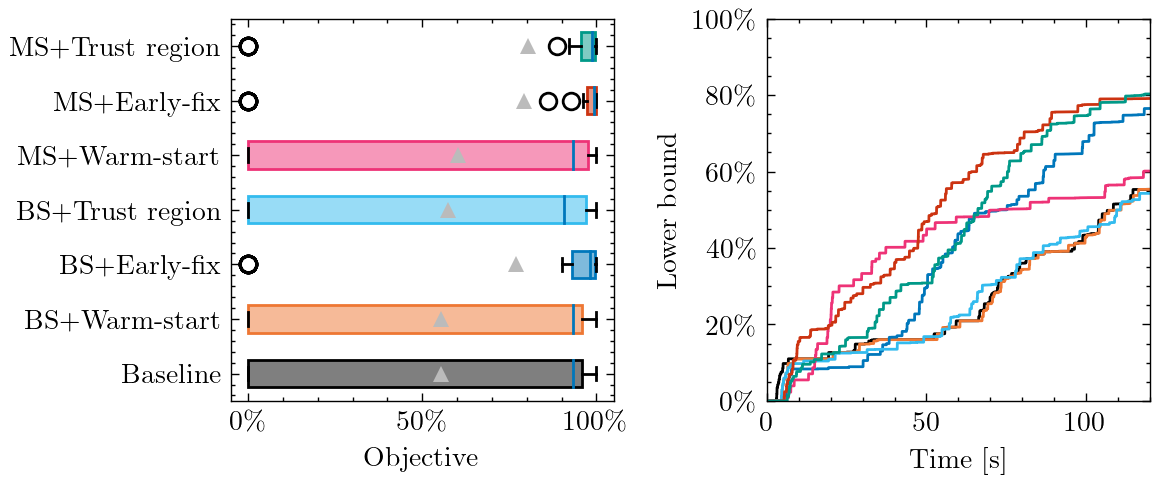

In [11]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(6, 2.625)

df = df[df['dataset'] == 'test']

def get_labels_values(df_, column):
    labels = list()
    valuess = list()
    for m, h in df_[['model', 'heuristic']].drop_duplicates().values:
        label = df_[(df_['model'] == m) & (df_['heuristic'] == h)]['plot_label'].values[0]
        labels.append(label)
        valuess.append(
            df_[(df_['model'] == m) & (df_['heuristic'] == h)][column].values
        )

    return labels, valuess

def plot_bounds(df_, ax):
    for m, h in df_[['model', 'heuristic']].drop_duplicates().values:
        label = df_[(df_['model'] == m) & (df_['heuristic'] == h)]['plot_label'].values[0]

        curve = df_[(df_['model'] == m) & (df_['heuristic'] == h)]['primal_curve'].mean()
        dt = TIME_BUDGET / (len(curve)-1)
        auc = np.sum(curve * dt)
        x = np.arange(len(curve)) * dt

        if m == 'Baseline':
            ax.plot(x, curve, color='black', label=f"Baseline ({auc:.2f})")
        else:
            ax.plot(x, curve, label=f"{label} ({auc:.2f})")
    ax.set_ylabel('Lower bound')
    ax.set_xlabel('Time [s]')
    ax.set_xlim(0,TIME_BUDGET)
    ax.set_ylim(0,1)
    # ax.grid()
    # ax.legend()

bar_colors = ['black',]+colors

df_obj = df[df['goal'] == 'obj']

labels, values = get_labels_values(df_obj, 'rel_obj')

bplot = axs[0].boxplot(values, labels=labels, vert=False, showmeans=True, patch_artist=True,
                       meanprops={'markerfacecolor': colors[6], 'markeredgewidth': 0})

for patch, color in zip(bplot['boxes'], bar_colors):
    c = to_rgba(color)
    c = (*c[:3], 0.5)
    patch.set_edgecolor(color)
    patch.set_facecolor(c)

axs[0].set_xlabel('Objective')

plot_bounds(df_obj, axs[1])

axs[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

fig.tight_layout()
fig.savefig('../heuristic_test_obj.pdf')
fig.show()

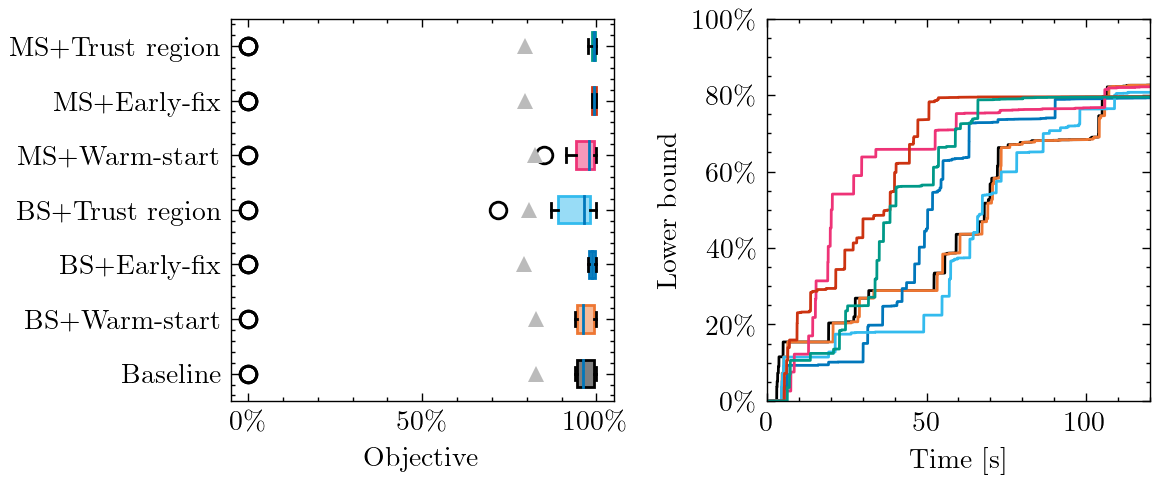

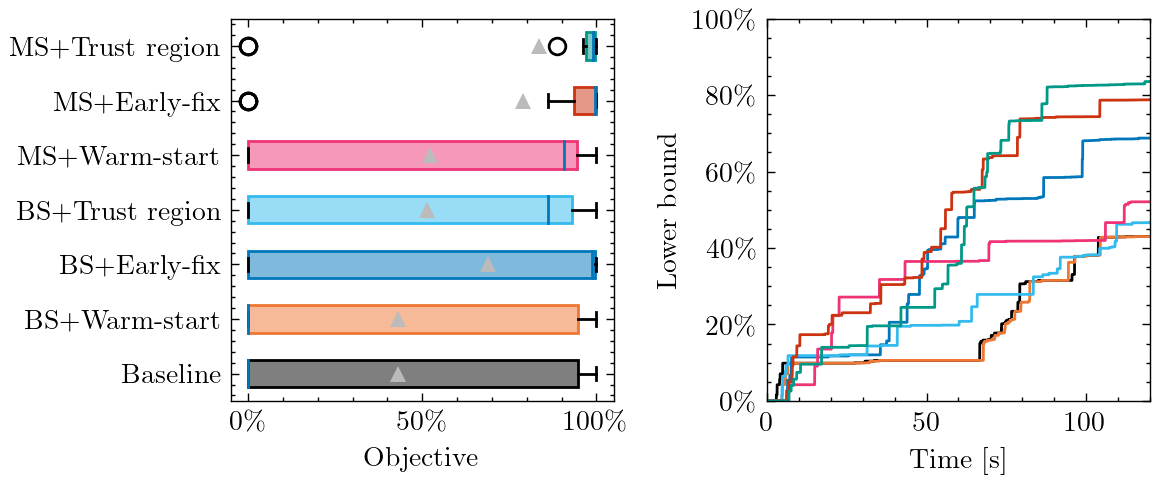

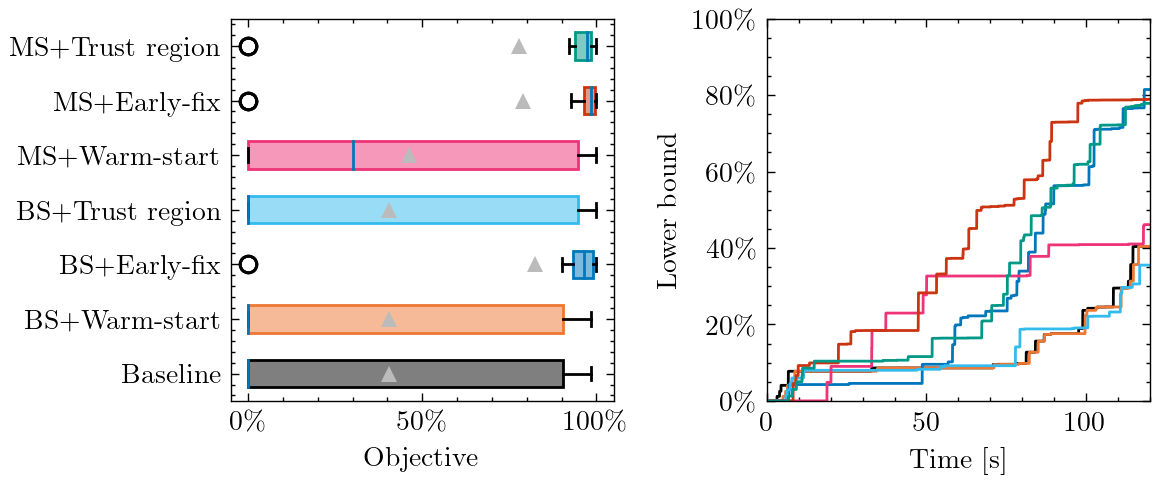

In [12]:
# fig, axss = plt.subplots(3,2)
# fig.set_size_inches(6, 3*2.625)

df_obj = df[df['goal'] == 'obj']

# for i, (s, axs) in enumerate(zip([20, 22, 24], axss)):
for s in [20, 22, 24]:
    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(6, 2.625)

    df_obj_s = df_obj[df_obj['size'] == s]

    labels, values = get_labels_values(df_obj_s, 'rel_obj')

    bplot = axs[0].boxplot(values, labels=labels, vert=False, showmeans=True, patch_artist=True,
                        meanprops={'markerfacecolor': colors[6], 'markeredgewidth': 0})

    for patch, color in zip(bplot['boxes'], bar_colors):
        c = to_rgba(color)
        c = (*c[:3], 0.5)
        patch.set_edgecolor(color)
        patch.set_facecolor(c)

    axs[0].set_xlabel('Objective')

    plot_bounds(df_obj_s, axs[1])

    axs[0].xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

    # axs[0].set_title(f'\# of jobs: {s}')
    # ax = fig.add_subplot(3,1,i+1, frameon=False)
    # ax.set_title(f'\# of jobs: {s}')
    # ax.set_xticks([])
    # ax.set_yticks([])

    fig.tight_layout()
    fig.savefig('../heuristic_test_obj_'+str(s)+'.pdf')
    fig.show()

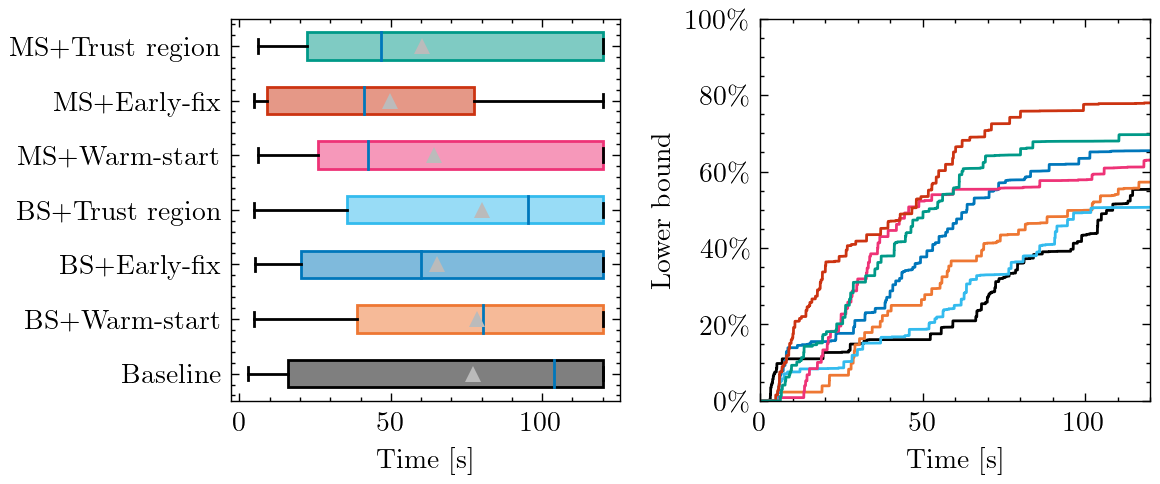

In [13]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(6, 2.625)

df_feas = df[df['goal'] == 'feas']

labels, values = get_labels_values(df_feas, 'time_to_feasible')

bplot = axs[0].boxplot(values, labels=labels, vert=False, showmeans=True, patch_artist=True,
                       meanprops={'markerfacecolor': colors[6], 'markeredgewidth': 0})

for patch, color in zip(bplot['boxes'], bar_colors):
    c = to_rgba(color)
    c = (*c[:3], 0.5)
    patch.set_edgecolor(color)
    patch.set_facecolor(c)

axs[0].set_xlabel('Time [s]')

plot_bounds(df_feas, axs[1])

axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

fig.tight_layout()
fig.savefig('../heuristic_test_feas.pdf')
fig.show()

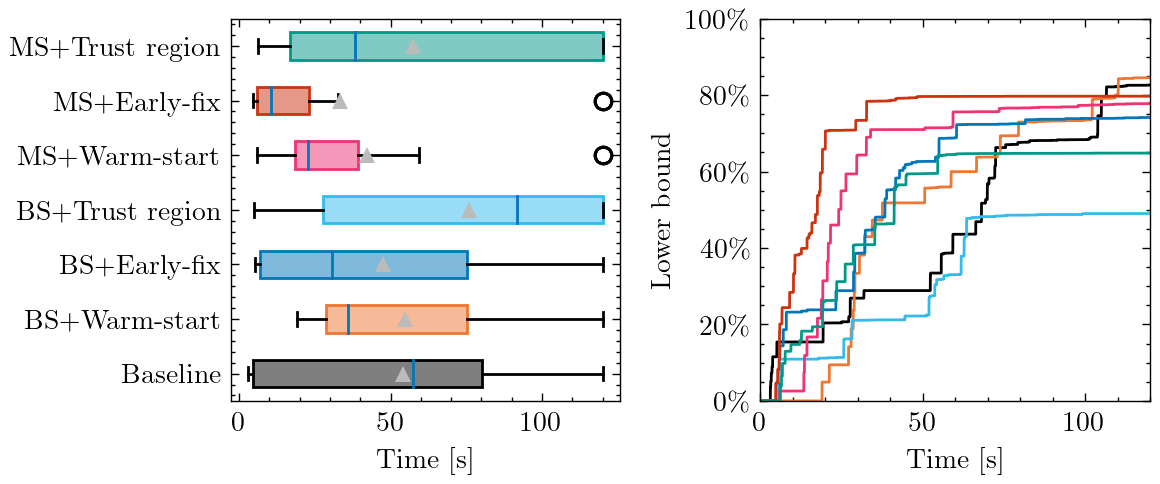

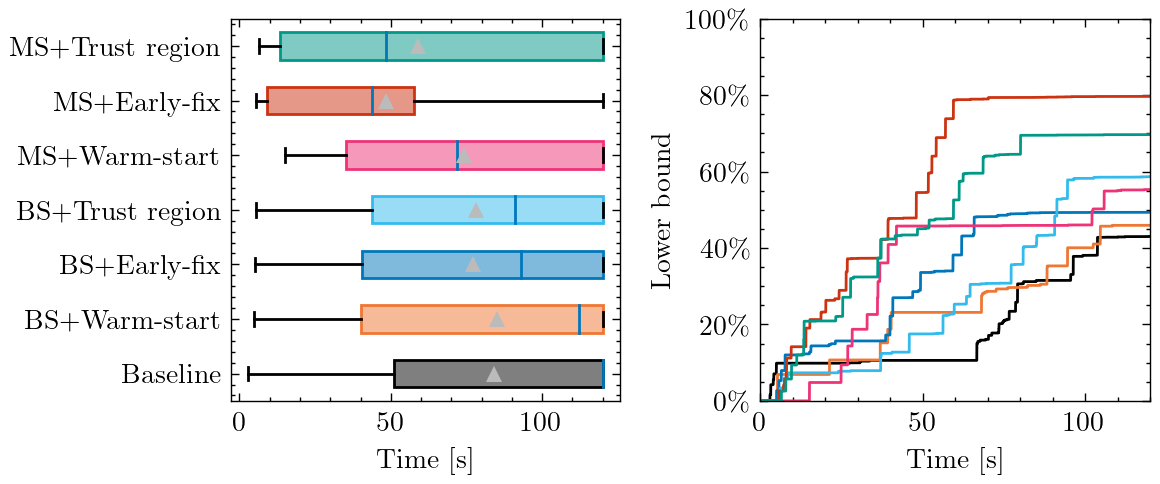

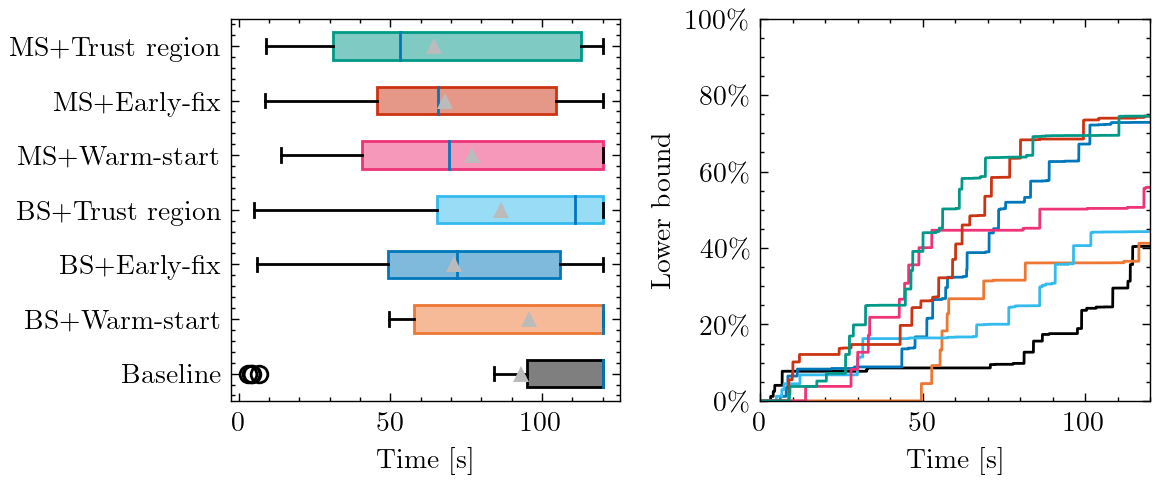

In [14]:
# fig, axss = plt.subplots(3,2)
# fig.set_size_inches(6, 3*2.625)

df_feas = df[df['goal'] == 'feas']

# for i, (s, axs) in enumerate(zip([20, 22, 24], axss)):
for s in [20, 22, 24]:
    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(6, 2.625)

    df_feas_s = df_feas[df_feas['size'] == s]

    labels, values = get_labels_values(df_feas_s, 'time_to_feasible')

    bplot = axs[0].boxplot(values, labels=labels, vert=False, showmeans=True, patch_artist=True,
                        meanprops={'markerfacecolor': colors[6], 'markeredgewidth': 0})

    for patch, color in zip(bplot['boxes'], bar_colors):
        c = to_rgba(color)
        c = (*c[:3], 0.5)
        patch.set_edgecolor(color)
        patch.set_facecolor(c)

    axs[0].set_xlabel('Time [s]')

    plot_bounds(df_feas_s, axs[1])

    axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

    # axs[0].set_title(f'\# of jobs: {s}')
    # ax = fig.add_subplot(3,1,i+1, frameon=False)
    # ax.set_title(f'\# of jobs: {s}')
    # ax.set_xticks([])
    # ax.set_yticks([])

    fig.tight_layout()
    fig.savefig('../heuristic_test_feas_'+str(s)+'.pdf')
    fig.show()

In [15]:
labels, values = get_labels_values('obj', 'rel_obj')
labels, list(map(np.mean, values))

TypeError: string indices must be integers

In [17]:
def plot_cdd_(column, goal, ax):
    d = df.sort_values(by=['size', 'size_id'])
    d = d[d['goal'] == goal]
    return d

d = plot_cdd_('rel_obj', 'obj', ax)

In [19]:
d.groupby('plot_label')['rel_obj']

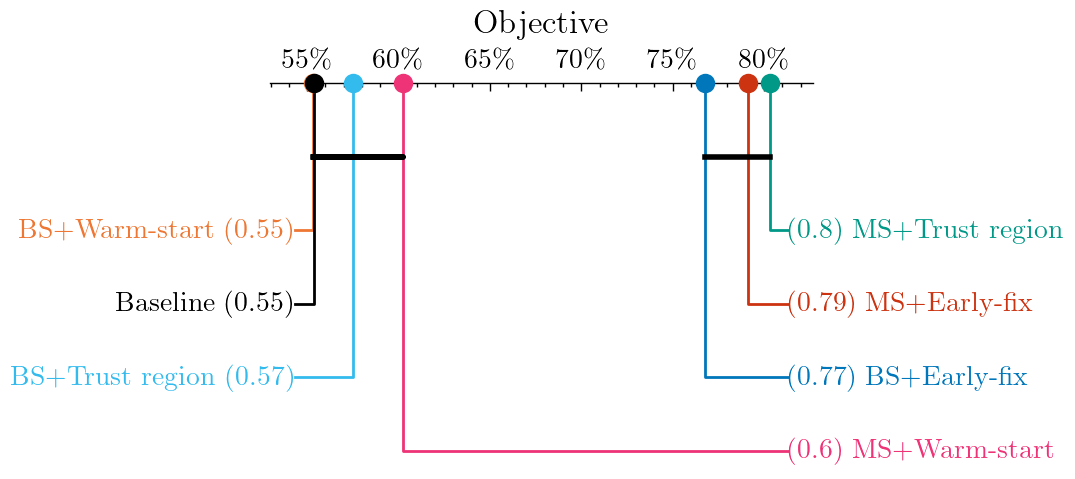

In [46]:
import scikit_posthocs as sp

def plot_cdd(column, goal, ax):
    d = df.sort_values(by=['size', 'size_id'])
    d = d[d['goal'] == goal]

    d[column] = d[column].astype(float)

    wilcoxon_matrix = sp.posthoc_wilcoxon(d, val_col=column, group_col='plot_label')

    artifacts = sp.critical_difference_diagram(d.groupby('plot_label')[column].mean(), wilcoxon_matrix, ax=ax)

    label_colors = dict(zip(labels, bar_colors))
    for marker, elbow, label in zip(artifacts['markers'], artifacts['elbows'], artifacts['labels']):
        artifact_label = label.get_text()
        for plot_label, color in label_colors.items():
            if plot_label in artifact_label:
                marker.set_color(color)
                elbow.set_color(color)
                label.set_color(color)

fig, ax = plt.subplots()
# fig.set_size_inches(3, 2*2.625)

plot_cdd('rel_obj', 'obj', ax)

ax.set_title('Objective')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

fig.savefig('../cdd_obj.pdf')
fig.show()

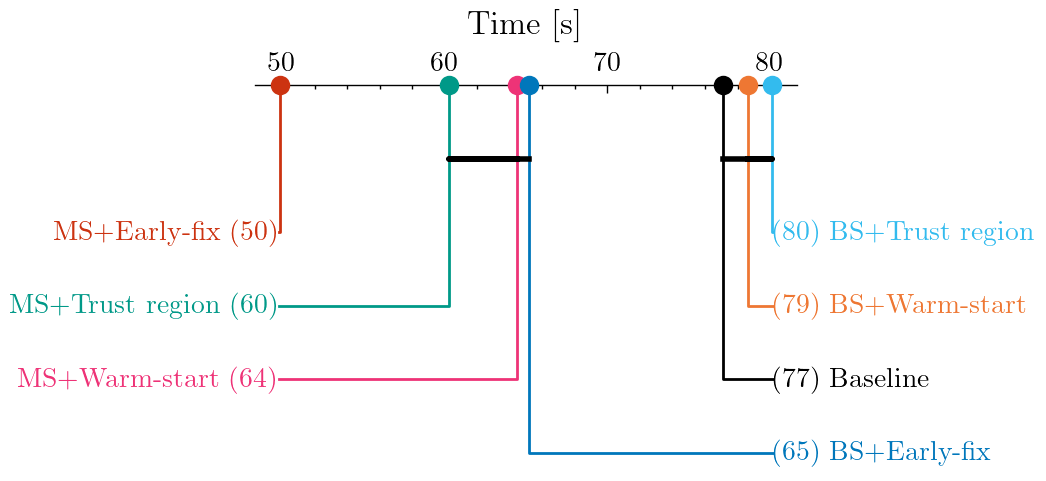

In [44]:
fig, ax = plt.subplots()

plot_cdd('time_to_feasible', 'feas', ax)

ax.set_title('Time [s]')

fig.savefig('../cdd_feas.pdf')
fig.show()

## varying hps

In [22]:
all_shortnames = set()
for fp in results_dir.glob(f"{net_ids['MultiTarget']}_*_{T}_*.json"):
    if int(fp.name.split('_')[-1][:-len('.json')]) < 20:
        continue

    if 'tr' in fp.name.split('_')[1]:
        all_shortnames.add('_'.join(fp.name.split('_')[:4]))
    else:
        all_shortnames.add('_'.join(fp.name.split('_')[:3]))

# all_shortnames = {'_'.join(fp.name.split('_')[:3]) for fp in results_dir.glob(f'{net_id}_*_{T}_*.json')}
all_shortnames.add('baseline_bs_0')
all_shortnames
for shortname in sorted(all_shortnames):
    print(shortname)
    print(len([fp for fp in results_dir.glob(shortname+f'_{T}_2*.json') if int(fp.name.split('_')[-1][:-len('.json')]) >= 20]))

baseline_bs_0
60
xae9giql_ef_1000
60
xae9giql_ef_1250
60
xae9giql_ef_1500
60
xae9giql_ef_1750
60
xae9giql_ef_2000
60
xae9giql_ef_500
60
xae9giql_ef_750
60
xae9giql_tr_1000_1
60
xae9giql_tr_1000_2
60
xae9giql_tr_1000_5
60
xae9giql_tr_1250_1
60
xae9giql_tr_1250_2
60
xae9giql_tr_1250_5
60
xae9giql_tr_1500_1
60
xae9giql_tr_1500_2
60
xae9giql_tr_1500_5
60
xae9giql_tr_1750_1
60
xae9giql_tr_1750_2
60
xae9giql_tr_1750_5
60
xae9giql_tr_2000_1
60
xae9giql_tr_2000_2
60
xae9giql_tr_2000_5
60
xae9giql_tr_500_1
60
xae9giql_tr_500_2
60
xae9giql_tr_500_5
60
xae9giql_tr_750_1
60
xae9giql_tr_750_2
60
xae9giql_tr_750_5
60
xae9giql_ws_1000
60
xae9giql_ws_1250
60
xae9giql_ws_1500
60
xae9giql_ws_1750
60
xae9giql_ws_2000
60
xae9giql_ws_500
60
xae9giql_ws_750
60


In [24]:
dfs = list()
for sn in all_shortnames:
    df = load_all_results(sn, results_dir, opts_dir, test=True)
    # if sn.split('_')[1] == 'bs':
    #     df['heuristic'] = 'Baseline'
    # elif sn.split('_')[1] == 'ws':
    #     df['heuristic'] = 'Warm-start'
    # elif sn.split('_')[1] == 'tr':
    #     df['heuristic'] = 'Trust region'
    # elif sn.split('_')[1] == 'ef':
    #     df['heuristic'] = 'Early-fix'
    df['heuristic'] = sn.split('_')[1]
    df['sn'] = sn
    df['n'] = int(sn.split('_')[2])
    if sn.split('_')[1] == 'tr':
        df['delta'] = int(sn.split('_')[-1])
    else:
        df['delta'] = 0
    dfs.append(df)
df = pd.concat(dfs)

df['rel_obj'] = df['objective'] / df['opt_obj']

df

,size,size_id,opt_obj,infeasible,runtime,objective,gap,primal_curve,time_to_feasible,heuristic,sn,n,delta,rel_obj
0,24,27,19002,False,120.007700,18599.000000,0.118554,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",47.464,ws,xae9giql_ws_1250,1250,0,0.978792
1,24,29,17200,True,120.004854,0.000000,-1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",120.000,ws,xae9giql_ws_1250,1250,0,0.0
2,20,21,13534,False,120.002155,12234.000000,0.127589,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",33.293,ws,xae9giql_ws_1250,1250,0,0.903946
3,22,24,9965,True,120.001976,0.000000,-1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",120.000,ws,xae9giql_ws_1250,1250,0,0.0
4,22,32,13823,False,120.001451,13155.999749,0.122147,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",33.924,ws,xae9giql_ws_1250,1250,0,0.951747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,20,33,16887,True,4.708969,0.000000,-1.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",120.000,tr,xae9giql_tr_1500_2,1500,2,0.0
56,22,30,14190,False,120.001544,14128.000000,0.005961,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",103.718,tr,xae9giql_tr_1500_2,1500,2,0.995631
57,20,21,13534,False,120.001471,13444.000000,0.022359,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",61.148,tr,xae9giql_tr_1500_2,1500,2,0.99335
58,20,29,14634,False,120.000272,14473.000000,0.039216,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",38.810,tr,xae9giql_tr_1500_2,1500,2,0.988998


In [25]:
df[df['heuristic'] == 'Baseline']

,size,size_id,opt_obj,infeasible,runtime,objective,gap,primal_curve,time_to_feasible,heuristic,sn,n,delta,rel_obj


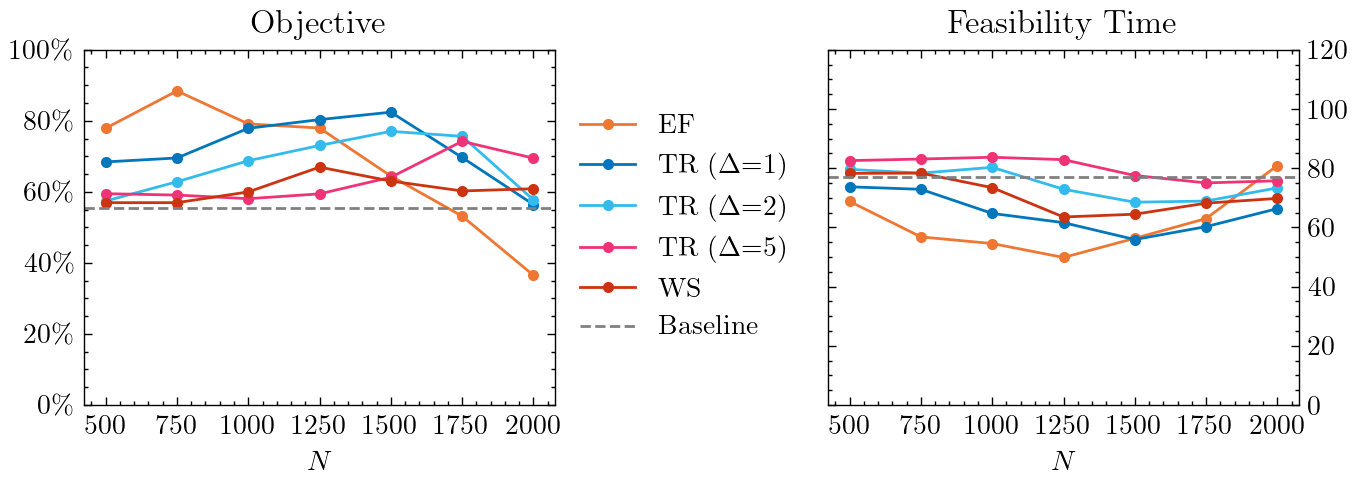

In [61]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(7, 2.625)

def make_lineplot(column, ax):
    means = df[df['heuristic'] != 'bs'].groupby(['heuristic', 'delta', 'n'])[column].mean().reset_index()
    # stds = df[df['heuristic'] != 'Baseline'].groupby(['heuristic', 'n'])['relative_objective'].std().reset_index()
    for h in means['heuristic'].unique():
        if h == 'tr':
            for delta in means[means['heuristic'] == h]['delta'].unique():
                h_means = means[(means['heuristic'] == h) & (means['delta'] == delta)].set_index('n')[column]

                ax.plot(h_means, marker='.', label=h.upper()+f' ($\Delta$={delta})')
        else:
            h_means = means[means['heuristic'] == h].set_index('n')[column]
            # h_stds = stds[stds['heuristic'] == h].set_index('n')['relative_objective']
            # plt.errorbar(h_means.index, h_means.values, yerr=h_stds.values, marker='.', label=h)
            ax.plot(h_means, marker='.', label=h.upper())

    baseline_obj = df[df['heuristic'] == 'bs'][column].mean()

    ax.set_xticks(means['n'].unique())

    xlim = ax.get_xlim()
    ax.hlines(baseline_obj, *xlim, label='Baseline', linestyles='dashed', color='gray')
    ax.set_xlim(*xlim)

make_lineplot('rel_obj', axs[0])

axs[0].set_ylim(0,1)
axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axs[0].set_title('Objective')
# axs[0].set_ylabel('Relative Value')
axs[0].set_xlabel('$N$')
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

make_lineplot('time_to_feasible', axs[1])

axs[1].set_ylim(0,120)
# axs[1].legend()
# axs[1].set_ylabel('Seconds')
axs[1].set_xlabel('$N$')
axs[1].set_title('Feasibility Time')
axs[1].yaxis.tick_right()
axs[1].yaxis.set_ticks_position('both')
axs[1].yaxis.set_label_position("right")

fig.tight_layout()
fig.savefig('../N_impact.pdf')
fig.show()

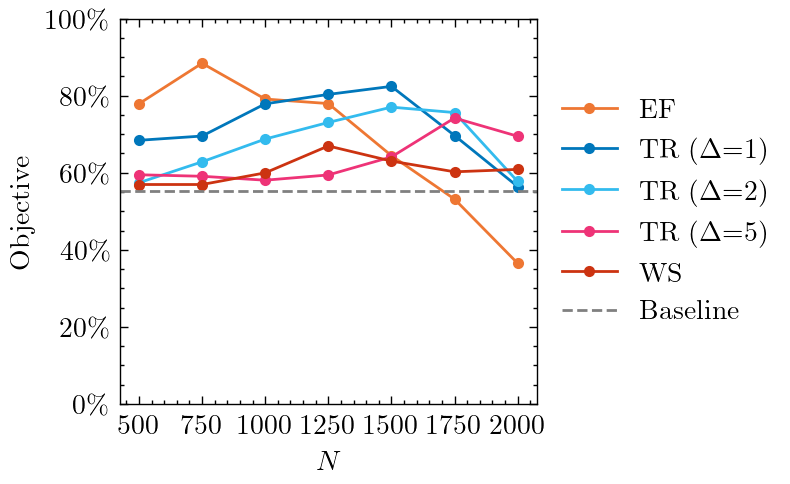

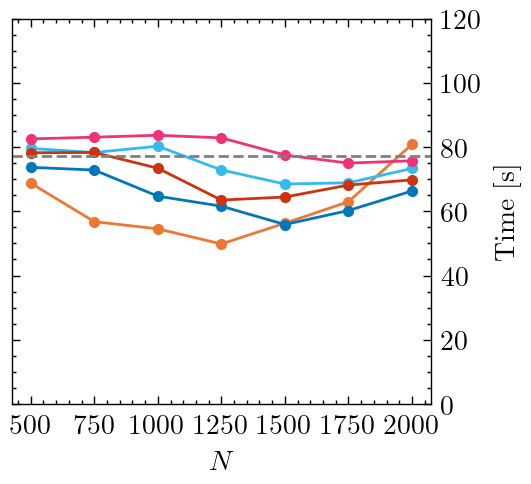

In [42]:
def make_lineplot(column, ax):
    means = df[df['heuristic'] != 'bs'].groupby(['heuristic', 'delta', 'n'])[column].mean().reset_index()
    # stds = df[df['heuristic'] != 'Baseline'].groupby(['heuristic', 'n'])['relative_objective'].std().reset_index()
    for h in means['heuristic'].unique():
        if h == 'tr':
            for delta in means[means['heuristic'] == h]['delta'].unique():
                h_means = means[(means['heuristic'] == h) & (means['delta'] == delta)].set_index('n')[column]

                ax.plot(h_means, marker='.', label=h.upper()+f' ($\Delta$={delta})')
        else:
            h_means = means[means['heuristic'] == h].set_index('n')[column]
            # h_stds = stds[stds['heuristic'] == h].set_index('n')['relative_objective']
            # plt.errorbar(h_means.index, h_means.values, yerr=h_stds.values, marker='.', label=h)
            ax.plot(h_means, marker='.', label=h.upper())

    baseline_obj = df[df['heuristic'] == 'bs'][column].mean()

    ax.set_xticks(means['n'].unique())

    xlim = ax.get_xlim()
    ax.hlines(baseline_obj, *xlim, label='Baseline', linestyles='dashed', color='gray')
    ax.set_xlim(*xlim)

fig, ax = plt.subplots()
fig.set_size_inches(4.15, 2.625)

make_lineplot('rel_obj', ax)

ax.set_ylim(0,1)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_title('Objective')
# axs[0].set_ylabel('Relative Value')
ax.set_xlabel('$N$')
ax.set_ylabel('Objective')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

fig.tight_layout()
fig.savefig('../N_impact_obj.pdf')
fig.show()

fig, ax = plt.subplots()
fig.set_size_inches(2.85, 2.625)

make_lineplot('time_to_feasible', ax)

ax.set_ylim(0,120)
ax.set_xlabel('$N$')
ax.set_ylabel('Time [s]')
# ax.set_title('Feasibility Time')
ax.yaxis.tick_right()
ax.yaxis.set_ticks_position('both')
ax.yaxis.set_label_position("right")

fig.tight_layout()
fig.savefig('../N_impact_feas.pdf')
fig.show()